In [6]:
#This code uses data from the "Picarro G2301" instrument (in this code: 'PICC') and the "Datalogger" (smaller screen, in this code: 'TNDL' ['ThiN-screen DataLogger']).
    #Creates a 2D line plot of [PICC parameter] level verus time (PICC only)
    #Rescales PICC data to match the real-time TKDL data
    #Creates a 2D scatter plot of latitude vs longitude with colours representing [PICC parameter] concentration 
    
#All you need to imput is: 
    # filename (PICC, TKDL)
    # location of where to save the output
    # UTC start time (PICC, TKDL)
    # date (TKDL)
    
    
#please note, the boxes need to be run in order

#Written by Merrilyn McKee for the Centre for Atmospheric Chemistry (University of Wollongong)
#January 2018

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
import pyproj
import LatLon


######################## USER INPUT REQUIRED ########################

#field trip information
location = 'UOW'
date_obt = '05-12-2017' #put in 'dd-mm-yyyy' format
aircorereplicate = '2'

#files to use
TNDL_ogfile = 'C:\Users\pokem\Google Drive\Applying for stuff\Wollongong Documents\Organised data\UOW\d051217\LOG0017.csv'
PICC_ogfile = 'C:\Users\pokem\Google Drive\Applying for stuff\Wollongong Documents\Organised data\UOW\d051217\CFADS2369-20171205-015932Z-DataLog_User.dat'
wheretosave = 'C:\Users\pokem\Google Drive\Applying for stuff\Wollongong Documents\Practise data\Complete code\output\.folder' #put \.folder after the folder for this to work

#sometimes the PICC data is spread over two files
second_PICC_file = 'Y' #Y or N; choose whether there is a second PICC file, if not, comment out the file below
PICC_ogfile2 = 'C:\Users\pokem\Google Drive\Applying for stuff\Wollongong Documents\Organised data\UOW\d051217\CFADS2369-20171205-025938Z-DataLog_User.dat'

#starting and ending times in UCT for the required data within the file
TNDL_start = '2017-12-05 01:38:00'
TNDL_end = '2017-12-05 01:49:00' 

PICC_start = '2017-12-05 02:25:10' #needs to be in date then time format
PICC_end = '2017-12-05 02:35:35'

######################## END USER INPUT REQUIRED ########################

#imports the required file, parses datetime and makes the datetime the index column
TNDL_data = pd.read_csv(TNDL_ogfile, delimiter = ',\s+', engine = 'python') #time is a weird format and doesn't include date and thus needs to be parsed separately
TNDL_data['UTC'] = TNDL_data['UTC'].apply(lambda x: '{0:0>6}'.format(x)) #puts the time into a 6-digit, zero-padded format
TNDL_data['UTC'] = pd.to_datetime(TNDL_data['UTC'], format = '%H%M%S')
reqdate = datetime.datetime.strptime(date_obt, '%d-%m-%Y')
TNDL_data['UTC'] = TNDL_data['UTC'].map(lambda x: pd.datetime(reqdate.year, reqdate.month, reqdate.day, x.hour, x.minute, x.second))
TNDL_data.index = TNDL_data['UTC']
TNDL_data = TNDL_data[TNDL_data.Lat != 0]

PICC_data = pd.read_csv(PICC_ogfile, delimiter=r'\s+', parse_dates=[['TIME','DATE']])
PICC_data.index = PICC_data['TIME_DATE']

#data for required parameters
PICC_CO2 = PICC_data['CO2']
PICC_CO2_dry = PICC_data['CO2_dry']
PICC_CH4 = PICC_data['CH4']
PICC_CH4_dry = PICC_data['CH4_dry']
PICC_H2O = PICC_data['H2O']

PICC_allydata = [PICC_CO2,PICC_CO2_dry,PICC_CH4,PICC_CH4_dry,PICC_H2O]
PICC_allydatanames = ['CO2','CO2_dry','CH4','CH4_dry','H2O']

#convert req times into datetime
TNDL_start_time = datetime.datetime.strptime(TNDL_start,'%Y-%m-%d %H:%M:%S')
TNDL_end_time = datetime.datetime.strptime(TNDL_end,'%Y-%m-%d %H:%M:%S')
PICC_start_time = datetime.datetime.strptime(PICC_start,'%Y-%m-%d %H:%M:%S')
PICC_end_time = datetime.datetime.strptime(PICC_end,'%Y-%m-%d %H:%M:%S')

#general for naming
filepart = wheretosave.split('.')[0]
filenamebeg = filepart + location + '_' + date_obt + '_rep' + aircorereplicate + '_TNDL_'
PICC_start_str = str(PICC_start_time.hour)+'h'+str(PICC_start_time.minute)+'m'+str(PICC_start_time.second)+'s'
PICC_end_str = str(PICC_end_time.hour)+'h'+str(PICC_end_time.minute)+'m'+str(PICC_end_time.second)+'s'

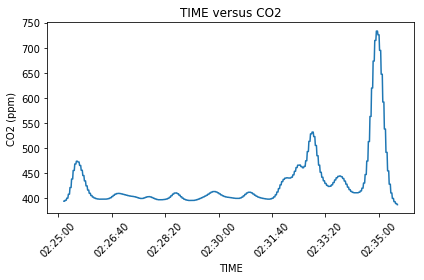

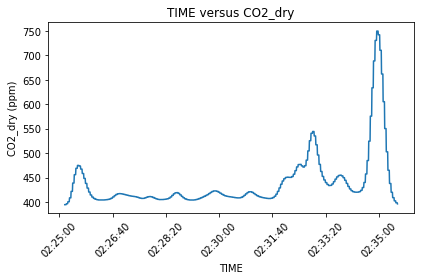

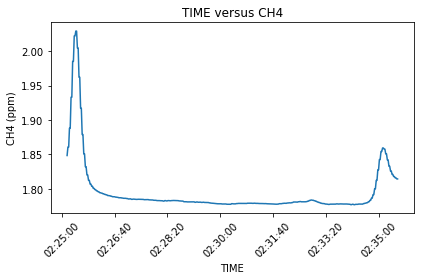

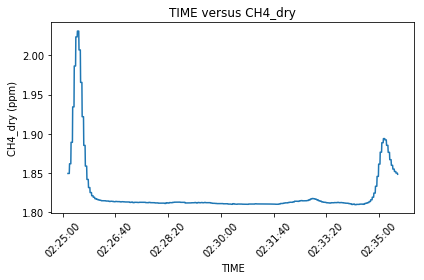

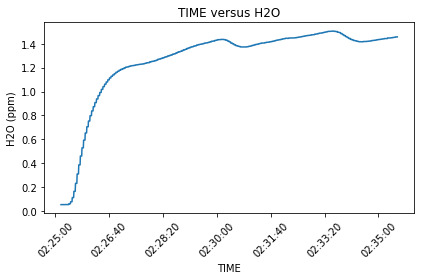

In [29]:
#plotting 2D PICC graphs of [parameter] vs Time    
i = 0
while i <len(PICC_allydata):
    
    x=PICC_data.TIME_DATE.dt.time
    y = PICC_allydata[i]
    xaxstr = 'TIME'
    y1axstr = PICC_allydatanames[i] + ' (ppm)'
    titl = xaxstr + ' versus ' + PICC_allydatanames[i]

    fig1=plt.plot(x[PICC_start:PICC_end],y[PICC_start:PICC_end])
    plt.title(titl)
    plt.xlabel(xaxstr)
    plt.ylabel(y1axstr)
    plt.xticks(rotation='45')
    plt.tight_layout()

    #saving the graphs as ready-named files
    filename = filenamebeg + xaxstr +'_vs_' + PICC_allydatanames[i] + '_graph'+'_'+PICC_start_str+'to'+PICC_end_str
    plt.gcf()
#     plt.savefig(filename+'.png')
    plt.show()
    
    i = i + 1

In [30]:
#determining the number of rows, time duration and rows per time for required data
TNDL_specnumrow = TNDL_data.Lat[TNDL_start: TNDL_end].count()
PICC_specnumrow = PICC_CO2[PICC_start_time : PICC_end_time].count()
TNDL_duration = (TNDL_end_time - TNDL_start_time).seconds
PICC_duration = (PICC_end_time - PICC_start_time).seconds
TNDL_dataden = 1.*TNDL_specnumrow/TNDL_duration
PICC_dataden = 1.*PICC_specnumrow/PICC_duration
reqratio = 1.*TNDL_duration/PICC_duration

print 'TNDL', 'number of rows =',(TNDL_specnumrow), '; number of seconds =',(TNDL_duration), '; rows/second',(TNDL_dataden)
print 'PICC', 'number of rows =',(PICC_specnumrow), '; number of seconds =',(PICC_duration), '; rows/second',(PICC_dataden)
print 'TNDL', type(TNDL_specnumrow), type(TNDL_duration), type(TNDL_dataden)
print 'PICC', type(PICC_specnumrow), type(PICC_duration), type(PICC_dataden)


TNDL number of rows = 584 ; number of seconds = 660 ; rows/second 0.884848484848
PICC number of rows = 625 ; number of seconds = 625 ; rows/second 1.0
TNDL <type 'numpy.int32'> <type 'int'> <type 'float'>
PICC <type 'numpy.int32'> <type 'int'> <type 'float'>


In [35]:
TNDL_newdf = TNDL_data[TNDL_start_time:TNDL_end_time]
TNDL_newdf.loc[:,'TNDL_timediff'] = np.nan
TNDL_newdf.loc[:,'TNDL_timediff'] = TNDL_newdf.loc[:,'UTC'] - TNDL_start_time

TNDL_newdf.index = TNDL_newdf.TNDL_timediff
TNDL_newdf = TNDL_newdf[~TNDL_newdf.index.duplicated(keep='first')]

PICC_newdf = PICC_data[PICC_start_time:PICC_end_time]
PICC_newdf.loc[:,'PICC_timediff'] = np.nan
PICC_newdf.loc[:,'PICC_timediff'] = PICC_newdf.loc[:,'TIME_DATE'] - PICC_start_time

PICC_newdf.loc[:,'tscaled'] = PICC_newdf.loc[:,'PICC_timediff']*reqratio
PICC_newdf.index = PICC_newdf.tscaled
PICC_newdf = PICC_newdf[~PICC_newdf.index.duplicated(keep='first')]

newdf = pd.concat([TNDL_newdf,PICC_newdf], axis = 1)
newdf= pd.DataFrame(newdf).interpolate(method='index')
newdf = newdf.resample('1S').pad()

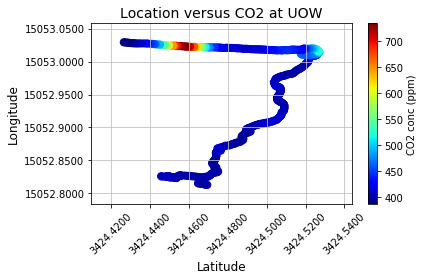

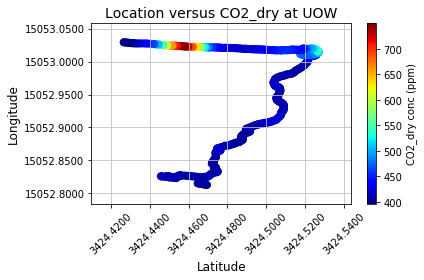

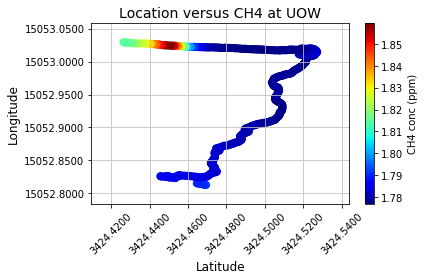

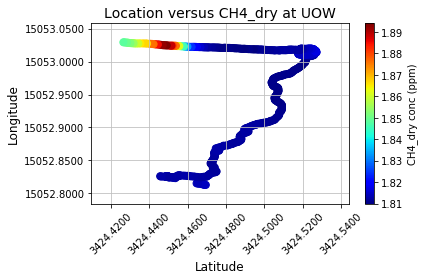

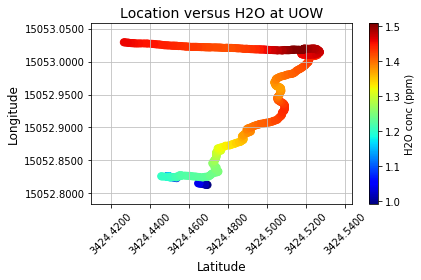

In [27]:
import matplotlib
from matplotlib  import cm
from matplotlib.ticker import FormatStrFormatter

#maximum and minimum parameters, used to make scalebar and axes
latmax = round(max(newdf.Lat),5)
latmin = round(min(newdf.Lat),5)
lonmax = round(max(newdf.Lon),5)
lonmin = round(min(newdf.Lon),5)

#making plotting easier
newdf_allydata = [newdf.CO2, newdf.CO2_dry, newdf.CH4, newdf.CH4_dry, newdf.H2O]
newdf_allydatanames = ['CO2','CO2_dry','CH4','CH4_dry','H2O']
newdf_allmax = ['CO2max', 'CO2_drymax', 'CH4max', 'CH4_drymax', 'H2Omax']
newdf_allmin = ['CO2min', 'CO2_drymin', 'CH4min', 'CH4_drymin', 'H2Omin']

#plotting 2D PICC graphs of lat vs lon with colourbar of [PICC parameter]    
i = 0
while i <len(PICC_allydata):
        
    x = newdf.Lat
    y = newdf.Lon
    z = newdf_allydata[i]
    xaxstr3d = 'Latitude'
    yaxstr3d = 'Longitude'
    zxstr3d = newdf_allydatanames[i] + ' (ppm)'
    titl = 'Location' + ' versus ' + newdf_allydatanames[i] + ' at '+ location
    cb_titl = newdf_allydatanames[i] + ' conc (ppm)'

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_title(titl,fontsize=14)
    ax.set_xlabel('Latitude',fontsize=12)
    ax.set_ylabel('Longitude',fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
#     ax.set_xlim([latmin-0.0002,latmax+0.0002])
#     ax.set_ylim([lonmin-0.0002,lonmax+0.0002])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    smhh = ax.scatter(x,y,c=z,s = 50, marker = 'o', cmap = cm.jet )
    plt.xticks(rotation='45')
    cb = plt.colorbar(smhh)
    cb.set_label(cb_titl)
    plt.tight_layout()
 
    #saving the graphs as ready-named files
    filename = filenamebeg + 'LatLon' +'_vs_' + newdf_allydatanames[i] + '_graph'+'_'+PICC_start_str+'to'+PICC_end_str
    plt.gcf()
    plt.savefig(filename+'.png')
    plt.show()
    
    i = i + 1

    
plt.close('all')